## Table of Contents

## 1. Dataset and Dependencies

###  1.1. Importing the necessary libraries

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

!pip install chart_studio
!pip install textstat
!pip install -U nltk
!pip install cufflinks
!pip install torchvision 
!pip install transformers


# text processing libraries
import re
import string 
import nltk
import numpy as np 
import pandas as pd 

from nltk.corpus import stopwords
lm=nltk.WordNetLemmatizer()
from datetime import datetime
import time

# Visualisation libraries
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly.figure_factory as ff
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# sklearn 
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,log_loss,accuracy_score, classification_report,precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, RidgeCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


# File system manangement
import os

# Pytorch
import torch

#Transformers
from transformers import BertTokenizer

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


!pip install wordcloud

from wordcloud import WordCloud


### 1.2. Reading in the Dataset

In [2]:
data = pd.read_csv("GPT.csv",encoding='ANSI')

# What is the shape of the dataset?
print("The input data has {} rows and {} columns" .format(len(data), len(data.columns)))


# First few rows of the training dataset
data.head()

The input data has 70 rows and 5 columns


,Requirement No,Description,Article No from Chat GPT,Article Text,Category
0,R45,ALLOW the data subjects to rectify their perso...,16,The data subject shall have the right to obtai...,UserParticipation
1,R7,ERASE the personal data when it has been unlaw...,19,The controller shall communicate any rectifica...,DataProcessing
2,R27,PROVIDE the data subjects the recipients/categ...,13(1)(e),Where personal data relating to a data subject...,Notice
3,R27,PROVIDE the data subjects the recipients/categ...,14(1)(e),Where personal data have not been obtained fro...,Notice
4,R35,OBTAIN the opt-in consent for the processing o...,6(1)(a),Processing shall be lawful only if and to the ...,UserParticipation


## 2. General EDA

### 2.1. Missing Vales

In [3]:
#how much missing data is there
print("Number of null values in the input: {}".format(data['Article Text'].isnull().sum()))

#Missing values in each column
print("\nNumber of null values in each column:")
data.isnull().sum()

Number of null values in the input: 0

Number of null values in each column:


Requirement No               0
Description                  0
Article No from Chat GPT     0
Article Text                 0
Category                     0
dtype: int64

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Article Text         70 non-null     object
 1   Category             70 non-null     object
 2   Article Text Length  70 non-null     int64 
 3   text_clean           70 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.3+ KB
None

Summary Statistics:
       Article Text Length
count            70.000000
mean            363.828571
std             132.563900
min              78.000000
25%             281.250000
50%             345.000000
75%             460.750000
max             664.000000

First Few Rows:
                                        Article Text           Category  \
0  The data subject shall have the right to obtai...  UserParticipation   
1  The controller shall communicate any rectifica...     DataProcessing   
2  Where personal data

<Figure size 576x432 with 0 Axes>

<AxesSubplot:xlabel='Category', ylabel='count'>

Text(0.5, 1.0, 'Distribution of Categories')

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Count')

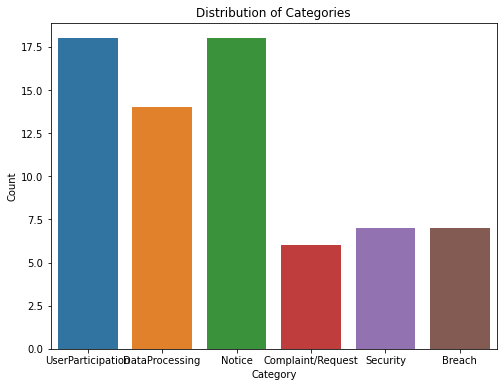

<Figure size 576x432 with 0 Axes>

<AxesSubplot:xlabel='Article Text Length', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of Article Text Lengths')

Text(0.5, 0, 'Article Text Length')

Text(0, 0.5, 'Count')

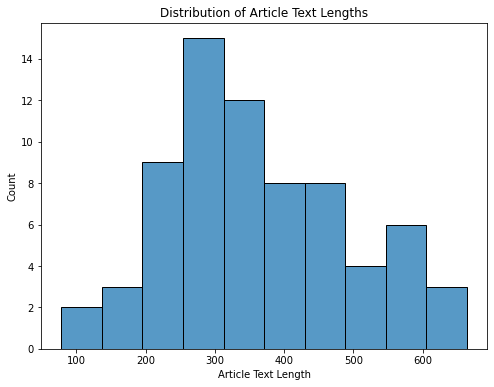

<Figure size 720x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Top 10 Most Common Words in Article Text')

Text(0.5, 0, 'Word')

Text(0, 0.5, 'Frequency')

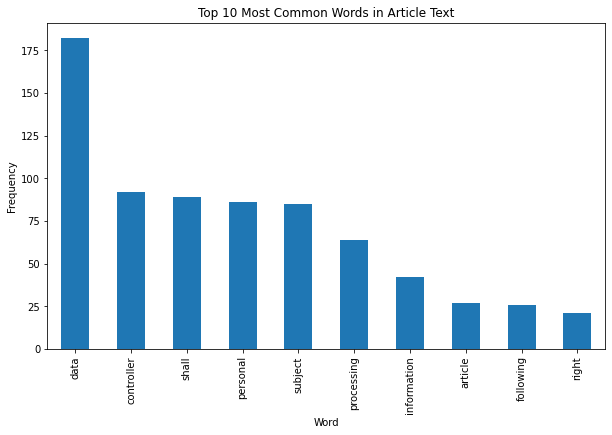

In [22]:

# Display basic information about the dataset
print("Dataset Information:")
print(data.info())

# Display summary statistics of numerical columns
print("\nSummary Statistics:")
print(data.describe())

# Display the first few rows of the dataset
print("\nFirst Few Rows:")
print(data.head())

# Visualize the distribution of categories
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Category')
plt.title("Distribution of Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

# Visualize the distribution of article text lengths
data['Article Text Length'] = data['Article Text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x='Article Text Length', bins=10)
plt.title("Distribution of Article Text Lengths")
plt.xlabel("Article Text Length")
plt.ylabel("Count")
plt.show()

# Display the most common words in the article text
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['Article Text'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
top_words = word_freq.sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_words.plot(kind='bar')
plt.title("Top 10 Most Common Words in Article Text")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()



## 3.Analysis of the catogory Column

Distribution of the catogory Column

In [5]:
data['Category'].value_counts()

UserParticipation    18
Notice               18
DataProcessing       14
Security              7
Breach                7
Complaint/Request     6
Name: Category, dtype: int64

In [6]:
data['Category'].value_counts(normalize=True)

UserParticipation    0.257143
Notice               0.257143
DataProcessing       0.200000
Security             0.100000
Breach               0.100000
Complaint/Request    0.085714
Name: Category, dtype: float64

In [7]:
data['Category'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='red',
                                                      theme='pearl',
                                                      bargap=0.6,
                                                      gridcolor='white',
                                                     
                                                      title='Distribution of Catogory column in the data set')

## 4. Text Data Preprocessing

### 4.1. Data Cleaning:

### 4.2. Data Reduction:

In [8]:

data.head()
data = data.drop(['Requirement No','Description','Article No from Chat GPT '], axis=1)
data.columns


,Requirement No,Description,Article No from Chat GPT,Article Text,Category,Article Text Length
0,R45,ALLOW the data subjects to rectify their perso...,16,The data subject shall have the right to obtai...,UserParticipation,350
1,R7,ERASE the personal data when it has been unlaw...,19,The controller shall communicate any rectifica...,DataProcessing,413
2,R27,PROVIDE the data subjects the recipients/categ...,13(1)(e),Where personal data relating to a data subject...,Notice,287
3,R27,PROVIDE the data subjects the recipients/categ...,14(1)(e),Where personal data have not been obtained fro...,Notice,216
4,R35,OBTAIN the opt-in consent for the processing o...,6(1)(a),Processing shall be lawful only if and to the ...,UserParticipation,212


Index(['Article Text', 'Category', 'Article Text Length'], dtype='object')

### 4.3. NLP text Preprocessing:

In [9]:
# text preprocessing helper functions

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
   
    
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text. Remove stop word and lemmatization

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    lemmatize_text=[lm.lemmatize(word) for word in remove_stopwords]
    combined_text = ' '.join(lemmatize_text)
    return combined_text

In [10]:
# Applying the cleaning function to both test and training datasets
data['text_clean'] = data['Article Text'].apply(str).apply(lambda x: text_preprocessing(x))
data.head()

,Article Text,Category,Article Text Length,text_clean
0,The data subject shall have the right to obtai...,UserParticipation,350,data subject shall right obtain controller wit...
1,The controller shall communicate any rectifica...,DataProcessing,413,controller shall communicate rectification era...
2,Where personal data relating to a data subject...,Notice,287,personal data relating data subject collected ...
3,Where personal data have not been obtained fro...,Notice,216,personal data obtained data subject controller...
4,Processing shall be lawful only if and to the ...,UserParticipation,212,processing shall lawful extent least one follo...


### 4.4. One hot encoding:

In [11]:
# Spliting the target variable into binary columns
security_class = ','.join(data['Category'].unique())
security_class = set(security_class.split(","))
df = data.copy()
for s in security_class:
    df[s]=0
    df.loc[df['Category'].str.contains(s, regex=False),s] = 1

In [12]:
df.head()

,Article Text,Category,Article Text Length,text_clean,DataProcessing,Breach,Complaint/Request,UserParticipation,Notice,Security
0,The data subject shall have the right to obtai...,UserParticipation,350,data subject shall right obtain controller wit...,0,0,0,1,0,0
1,The controller shall communicate any rectifica...,DataProcessing,413,controller shall communicate rectification era...,1,0,0,0,0,0
2,Where personal data relating to a data subject...,Notice,287,personal data relating data subject collected ...,0,0,0,0,1,0
3,Where personal data have not been obtained fro...,Notice,216,personal data obtained data subject controller...,0,0,0,0,1,0
4,Processing shall be lawful only if and to the ...,UserParticipation,212,processing shall lawful extent least one follo...,0,0,0,1,0,0


In [13]:
for s in security_class:
    df[s].value_counts()

0    56
1    14
Name: DataProcessing, dtype: int64

0    63
1     7
Name: Breach, dtype: int64

0    64
1     6
Name: Complaint/Request, dtype: int64

0    52
1    18
Name: UserParticipation, dtype: int64

0    52
1    18
Name: Notice, dtype: int64

0    63
1     7
Name: Security, dtype: int64

## 5. Feature Extraction

### 5.1. Countvectorizer

In [14]:
## Applying Countvectorizer

# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(df['text_clean']).toarray()
cv.get_feature_names_out()
print(X)
X.shape





array(['ability', 'ability ensure', 'ability ensure ongoing', ...,
       'written', 'written declaration', 'written declaration also'],
      dtype=object)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(70, 2572)

### 5.2. TF IDF vectorization

In [15]:
# # Applying TF IDF vectorization

# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
# X=tfidf_v.fit_transform(df['text_clean']).toarray()

## 6. Machine Learning Models

### 6.1. Logistic Regression

Logistic Regression:


LogisticRegression()

LogisticRegression()

LogisticRegression()

LogisticRegression()

LogisticRegression()

Notice 
 Average Accuracy: 92.857
 Average Precision: 94.369
 Average Recall: 92.857
 Average F1 Score: 92.651
 Confusion Matrix:
 [[51.  1.]
 [ 4. 14.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Notice')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

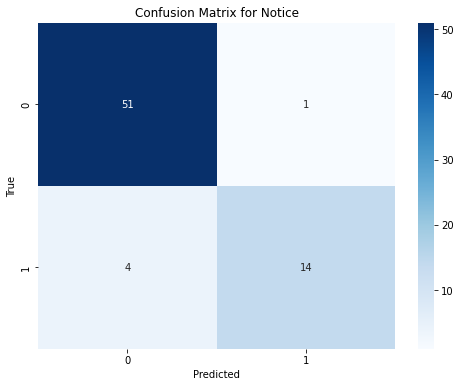

LogisticRegression()

LogisticRegression()

LogisticRegression()

LogisticRegression()

LogisticRegression()

Breach 
 Average Accuracy: 92.857
 Average Precision: 89.521
 Average Recall: 92.857
 Average F1 Score: 90.255
 Confusion Matrix:
 [[63.  0.]
 [ 5.  2.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Breach')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

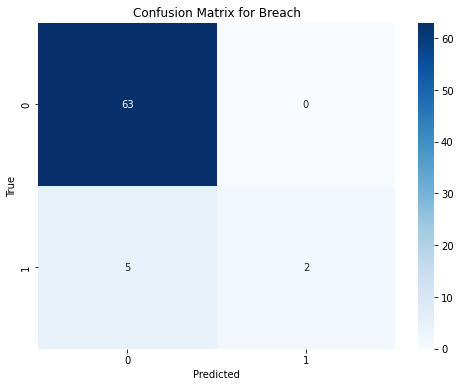

LogisticRegression()

LogisticRegression()

LogisticRegression()

LogisticRegression()

LogisticRegression()

DataProcessing 
 Average Accuracy: 94.286
 Average Precision: 94.805
 Average Recall: 94.286
 Average F1 Score: 94.071
 Confusion Matrix:
 [[55.  1.]
 [ 3. 11.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for DataProcessing')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

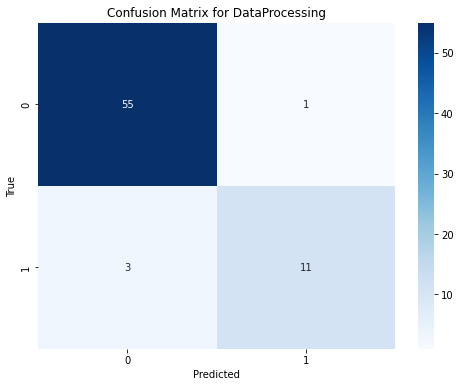

LogisticRegression()

LogisticRegression()

LogisticRegression()

LogisticRegression()

LogisticRegression()

Security 
 Average Accuracy: 95.714
 Average Precision: 94.626
 Average Recall: 95.714
 Average F1 Score: 94.803
 Confusion Matrix:
 [[63.  0.]
 [ 3.  4.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Security')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

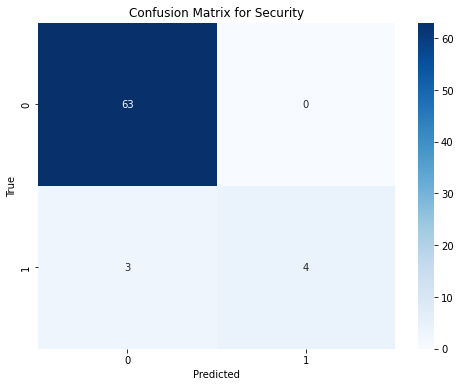

LogisticRegression()

LogisticRegression()

LogisticRegression()

LogisticRegression()

LogisticRegression()

Complaint/Request 
 Average Accuracy: 91.429
 Average Precision: 84.286
 Average Recall: 91.429
 Average F1 Score: 87.536
 Confusion Matrix:
 [[64.  0.]
 [ 6.  0.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Complaint/Request')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

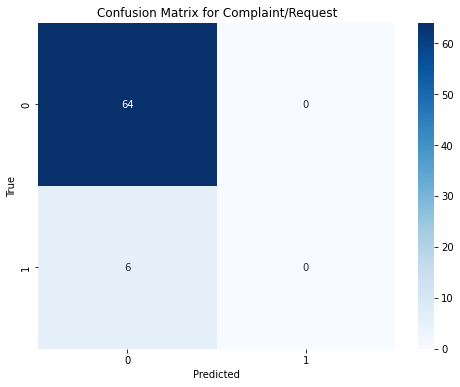

LogisticRegression()

LogisticRegression()

LogisticRegression()

LogisticRegression()

LogisticRegression()

UserParticipation 
 Average Accuracy: 78.571
 Average Precision: 84.321
 Average Recall: 78.571
 Average F1 Score: 77.507
 Confusion Matrix:
 [[47.  5.]
 [10.  8.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for UserParticipation')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

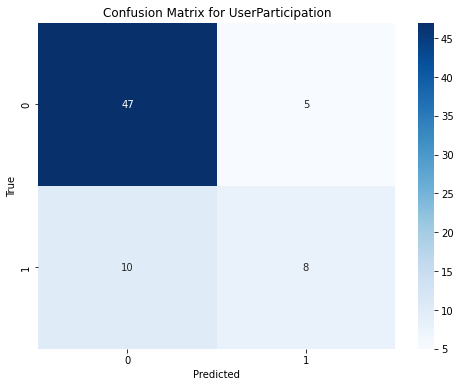

In [16]:


Round = 3  
fields = ['Notice', 'Breach', 'DataProcessing', 'Security', 'Complaint/Request', 'UserParticipation']

print('Logistic Regression:')

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=1)

for fold in fields:
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    fold_cm = np.zeros((len(np.unique(df[fold])), len(np.unique(df[fold]))))

    for train_index, val_index in kf.split(X):
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = df[fold][train_index], df[fold][val_index]

        logistic_regression = LogisticRegression()  
        logistic_regression.fit(x_train, y_train)
        test_pred = logistic_regression.predict(x_val)
        
        

        # Update confusion matrix for the fold
        fold_cm += confusion_matrix(y_val, test_pred, labels=np.unique(df[fold]))

     
        accuracy = accuracy_score(y_val, test_pred) * 100
        precision = precision_score(y_val, test_pred, average='weighted') * 100
        recall = recall_score(y_val, test_pred, average='weighted') * 100
        f1 = f1_score(y_val, test_pred, average='weighted') * 100

        fold_accuracies.append(accuracy)
        fold_precisions.append(precision)
        fold_recalls.append(recall)
        fold_f1_scores.append(f1)

    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_precision = np.mean(fold_precisions)
    avg_recall = np.mean(fold_recalls)
    avg_f1_score = np.mean(fold_f1_scores)
    print(f"{fold} ")
    print(f" Average Accuracy: {avg_accuracy:.{Round}f}")
    print(f" Average Precision: {avg_precision:.{Round}f}")
    print(f" Average Recall: {avg_recall:.{Round}f}")
    print(f" Average F1 Score: {avg_f1_score:.{Round}f}")
    
    # Print and plot the confusion matrix
    print(f" Confusion Matrix:\n {fold_cm}")
    
    # Plot the heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(fold_cm, annot=True, fmt="g", cmap="Blues", xticklabels=np.unique(df[fold]), yticklabels=np.unique(df[fold]))
    plt.title(f"Confusion Matrix for {fold}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


### 6.2. Random Forest

Random Forest:
Notice 
 Average Accuracy: 92.857
 Average Precision: 0.944
 Average Recall: 0.929
 Average F1 Score: 0.927
 Confusion Matrix:
 [[51.  1.]
 [ 4. 14.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Notice')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

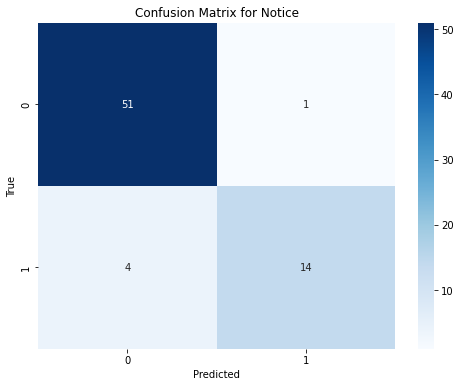

Breach 
 Average Accuracy: 90.000
 Average Precision: 0.815
 Average Recall: 0.900
 Average F1 Score: 0.854
 Confusion Matrix:
 [[63.  0.]
 [ 7.  0.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Breach')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

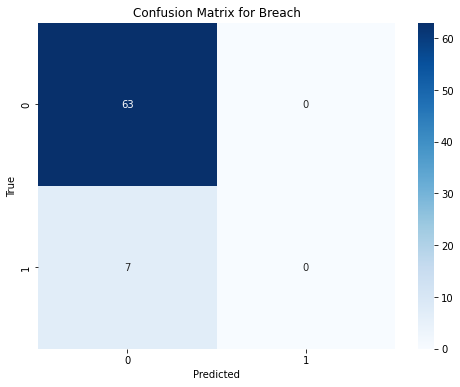

DataProcessing 
 Average Accuracy: 94.286
 Average Precision: 0.948
 Average Recall: 0.943
 Average F1 Score: 0.941
 Confusion Matrix:
 [[55.  1.]
 [ 3. 11.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for DataProcessing')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

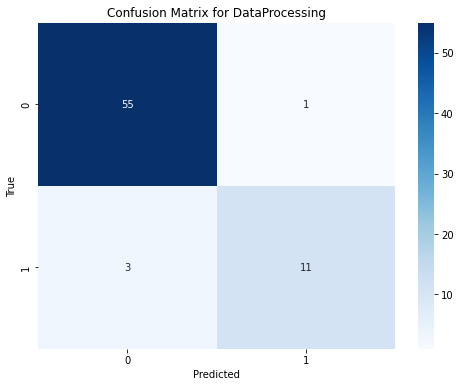

Security 
 Average Accuracy: 95.714
 Average Precision: 0.946
 Average Recall: 0.957
 Average F1 Score: 0.948
 Confusion Matrix:
 [[63.  0.]
 [ 3.  4.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Security')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

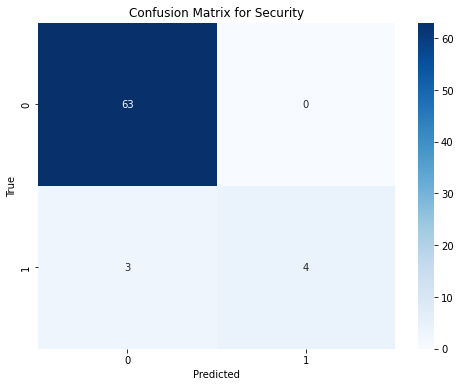

Complaint/Request 
 Average Accuracy: 91.429
 Average Precision: 0.843
 Average Recall: 0.914
 Average F1 Score: 0.875
 Confusion Matrix:
 [[64.  0.]
 [ 6.  0.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Complaint/Request')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

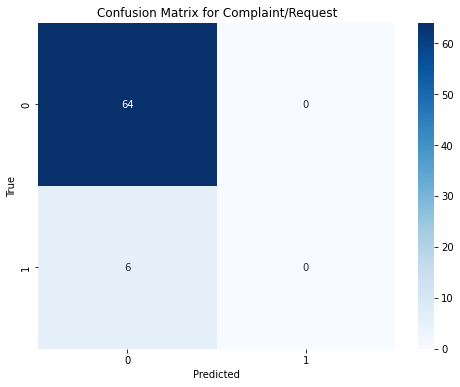

UserParticipation 
 Average Accuracy: 74.286
 Average Precision: 0.673
 Average Recall: 0.743
 Average F1 Score: 0.686
 Confusion Matrix:
 [[49.  3.]
 [15.  3.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for UserParticipation')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

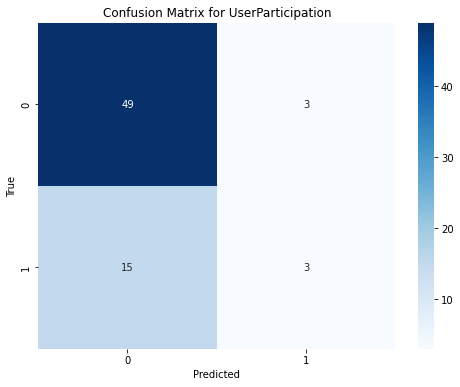

In [17]:


Round = 3  
fields = ['Notice', 'Breach', 'DataProcessing', 'Security', 'Complaint/Request', 'UserParticipation']

print('Random Forest:')

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=1)

for fold in fields:
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    fold_cm = np.zeros((len(np.unique(df[fold])), len(np.unique(df[fold]))))

    for train_index, val_index in kf.split(X):
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = df[fold][train_index], df[fold][val_index]

        rf = RandomForestClassifier()
        Rf = rf.fit(x_train, y_train)
        test_pred = Rf.predict(x_val)
        accuracy = accuracy_score(y_val, test_pred) * 100
        fold_accuracies.append(accuracy)

        # Update confusion matrix for the fold
        fold_cm += confusion_matrix(y_val, test_pred, labels=np.unique(df[fold]))

        # Calculate precision, recall, specificity, and F1 score for the fold
        precision = precision_score(y_val, test_pred, average='weighted')*100
        recall = recall_score(y_val, test_pred, average='weighted')*100
        f1 = f1_score(y_val, test_pred, average='weighted')*100

        fold_precisions.append(precision)
        fold_recalls.append(recall)
        fold_f1_scores.append(f1)

    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_precision = np.mean(fold_precisions)
    avg_recall = np.mean(fold_recalls)
    avg_f1_score = np.mean(fold_f1_scores)
    print(f"{fold} ")
    print(f" Average Accuracy: {avg_accuracy:.{Round}f}")
    print(f" Average Precision: {avg_precision:.{Round}f}")
    print(f" Average Recall: {avg_recall:.{Round}f}")
    print(f" Average F1 Score: {avg_f1_score:.{Round}f}")
    
    # Print and plot the confusion matrix
    print(f" Confusion Matrix:\n {fold_cm}")
    
    # Plot the heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(fold_cm, annot=True, fmt="g", cmap="Blues", xticklabels=np.unique(df[fold]), yticklabels=np.unique(df[fold]))
    plt.title(f"Confusion Matrix for {fold}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


### 6.3. Support Vector Machines

Support Vector Machines:


SVC()

SVC()

SVC()

SVC()

SVC()

Notice 
 Average Accuracy: 92.857
 Average Precision: 0.944
 Average Recall: 0.929
 Average F1 Score: 0.927
 Confusion Matrix:
 [[51.  1.]
 [ 4. 14.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Notice')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

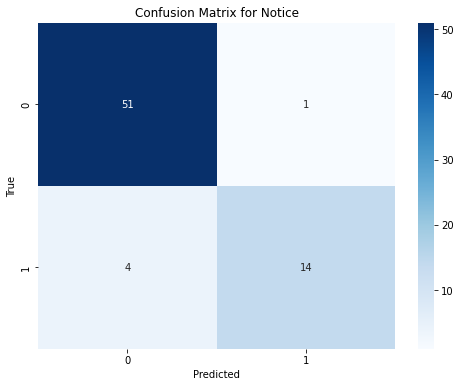

SVC()

SVC()

SVC()

SVC()

SVC()

Breach 
 Average Accuracy: 90.000
 Average Precision: 0.815
 Average Recall: 0.900
 Average F1 Score: 0.854
 Confusion Matrix:
 [[63.  0.]
 [ 7.  0.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Breach')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

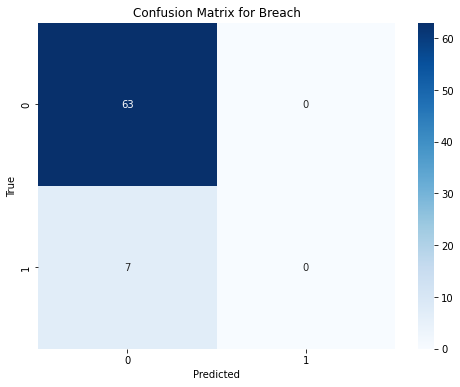

SVC()

SVC()

SVC()

SVC()

SVC()

DataProcessing 
 Average Accuracy: 94.286
 Average Precision: 0.950
 Average Recall: 0.943
 Average F1 Score: 0.938
 Confusion Matrix:
 [[56.  0.]
 [ 4. 10.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for DataProcessing')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

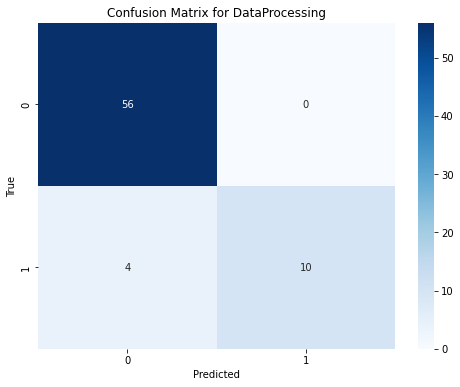

SVC()

SVC()

SVC()

SVC()

SVC()

Security 
 Average Accuracy: 95.714
 Average Precision: 0.946
 Average Recall: 0.957
 Average F1 Score: 0.948
 Confusion Matrix:
 [[63.  0.]
 [ 3.  4.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Security')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

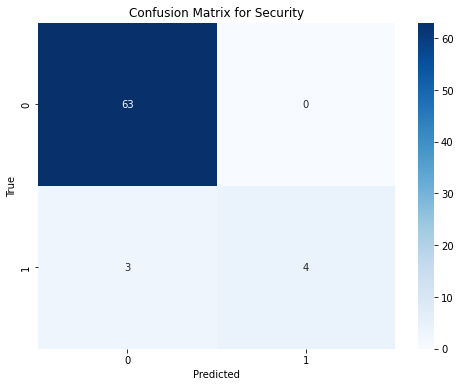

SVC()

SVC()

SVC()

SVC()

SVC()

Complaint/Request 
 Average Accuracy: 91.429
 Average Precision: 0.843
 Average Recall: 0.914
 Average F1 Score: 0.875
 Confusion Matrix:
 [[64.  0.]
 [ 6.  0.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Complaint/Request')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

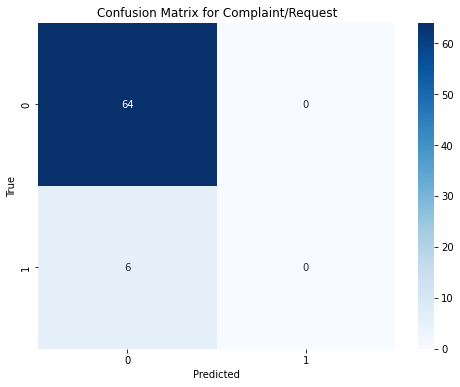

SVC()

SVC()

SVC()

SVC()

SVC()

UserParticipation 
 Average Accuracy: 74.286
 Average Precision: 0.639
 Average Recall: 0.743
 Average F1 Score: 0.672
 Confusion Matrix:
 [[50.  2.]
 [16.  2.]]


<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for UserParticipation')

Text(0.5, 33.0, 'Predicted')

Text(51.0, 0.5, 'True')

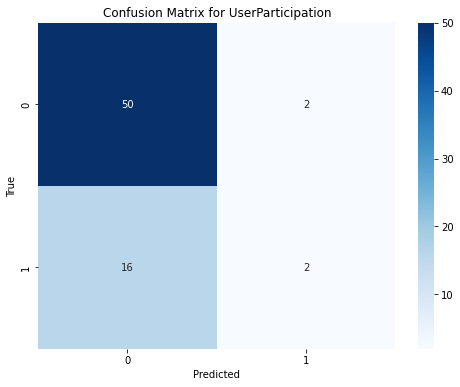

In [18]:


Round = 3  
fields = ['Notice', 'Breach', 'DataProcessing', 'Security', 'Complaint/Request', 'UserParticipation']

print('Support Vector Machines:')

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=1)

for fold in fields:
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    fold_cm = np.zeros((len(np.unique(df[fold])), len(np.unique(df[fold]))))

    for train_index, val_index in kf.split(X):
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = df[fold][train_index], df[fold][val_index]

        svm = SVC()  
        svm.fit(x_train, y_train)
        test_pred = svm.predict(x_val)
        accuracy = accuracy_score(y_val, test_pred) * 100
        fold_accuracies.append(accuracy)

        # Update confusion matrix for the fold
        fold_cm += confusion_matrix(y_val, test_pred, labels=np.unique(df[fold]))

        # Calculate precision, recall, specificity, and F1 score for the fold
        precision = precision_score(y_val, test_pred, average='weighted')*100
        recall = recall_score(y_val, test_pred, average='weighted')*100
        f1 = f1_score(y_val, test_pred, average='weighted')*100

        fold_precisions.append(precision)
        fold_recalls.append(recall)
        fold_f1_scores.append(f1)

    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_precision = np.mean(fold_precisions)
    avg_recall = np.mean(fold_recalls)
    avg_f1_score = np.mean(fold_f1_scores)
    print(f"{fold} ")
    print(f" Average Accuracy: {avg_accuracy:.{Round}f}")
    print(f" Average Precision: {avg_precision:.{Round}f}")
    print(f" Average Recall: {avg_recall:.{Round}f}")
    print(f" Average F1 Score: {avg_f1_score:.{Round}f}")
    
    # Print and plot the confusion matrix
    print(f" Confusion Matrix:\n {fold_cm}")
    
    # Plot the heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(fold_cm, annot=True, fmt="g", cmap="Blues", xticklabels=np.unique(df[fold]), yticklabels=np.unique(df[fold]))
    plt.title(f"Confusion Matrix for {fold}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


### 6.4. Decision Trees

Decision Trees:


DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

Notice 
 Average Accuracy: 97.143
 Average Precision: 97.464
 Average Recall: 97.143
 Average F1 Score: 97.094
 Confusion Matrix:
 [[52.  0.]
 [ 2. 16.]]


<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Notice')

Text(0.5, 15.0, 'Predicted')

Text(33.0, 0.5, 'True')

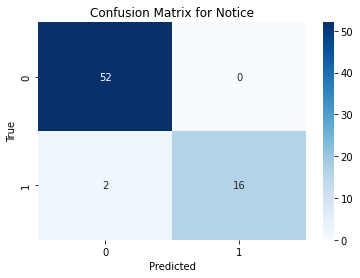

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

Breach 
 Average Accuracy: 94.286
 Average Precision: 95.824
 Average Recall: 94.286
 Average F1 Score: 94.764
 Confusion Matrix:
 [[61.  2.]
 [ 2.  5.]]


<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Breach')

Text(0.5, 15.0, 'Predicted')

Text(33.0, 0.5, 'True')

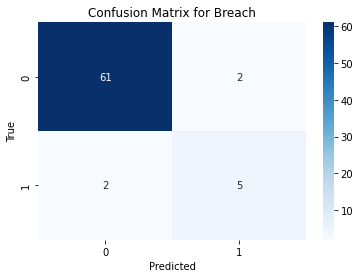

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

DataProcessing 
 Average Accuracy: 92.857
 Average Precision: 93.734
 Average Recall: 92.857
 Average F1 Score: 92.711
 Confusion Matrix:
 [[54.  2.]
 [ 3. 11.]]


<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for DataProcessing')

Text(0.5, 15.0, 'Predicted')

Text(33.0, 0.5, 'True')

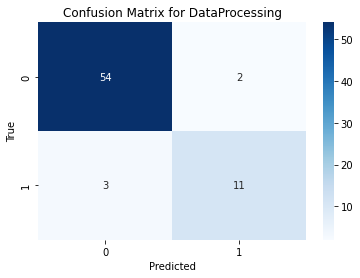

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

Security 
 Average Accuracy: 90.000
 Average Precision: 92.221
 Average Recall: 90.000
 Average F1 Score: 90.780
 Confusion Matrix:
 [[59.  4.]
 [ 3.  4.]]


<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Security')

Text(0.5, 15.0, 'Predicted')

Text(33.0, 0.5, 'True')

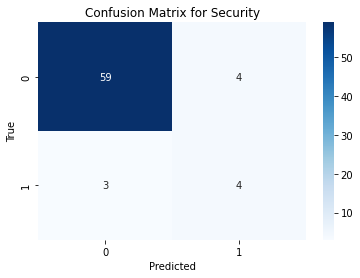

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

Complaint/Request 
 Average Accuracy: 91.429
 Average Precision: 84.286
 Average Recall: 91.429
 Average F1 Score: 87.536
 Confusion Matrix:
 [[64.  0.]
 [ 6.  0.]]


<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for Complaint/Request')

Text(0.5, 15.0, 'Predicted')

Text(33.0, 0.5, 'True')

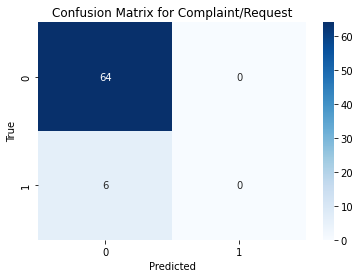

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

DecisionTreeClassifier()

UserParticipation 
 Average Accuracy: 82.857
 Average Precision: 86.094
 Average Recall: 82.857
 Average F1 Score: 83.000
 Confusion Matrix:
 [[45.  7.]
 [ 5. 13.]]


<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Confusion Matrix for UserParticipation')

Text(0.5, 15.0, 'Predicted')

Text(33.0, 0.5, 'True')

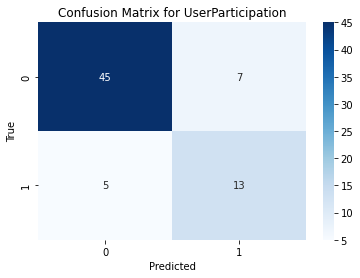

In [20]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

Round = 3  
fields = ['Notice', 'Breach', 'DataProcessing', 'Security', 'Complaint/Request', 'UserParticipation']

print('Decision Trees:')
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=1)

for fold in fields:
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []
    fold_f1_scores = []
    fold_cm = np.zeros((len(np.unique(df[fold])), len(np.unique(df[fold]))))

    for train_index, val_index in kf.split(X):
        x_train, x_val = X[train_index], X[val_index]
        y_train, y_val = df[fold][train_index], df[fold][val_index]

        decision_tree = DecisionTreeClassifier(max_depth=None) 
        decision_tree.fit(x_train, y_train)
        test_pred = decision_tree.predict(x_val)
        accuracy = accuracy_score(y_val, test_pred) * 100
        fold_accuracies.append(accuracy)

        # Update confusion matrix for the fold
        fold_cm += confusion_matrix(y_val, test_pred, labels=np.unique(df[fold]))

        # Calculate precision, recall, specificity, and F1 score for the fold
        precision = precision_score(y_val, test_pred, average='weighted')*100
        recall = recall_score(y_val, test_pred, average='weighted')*100
        f1 = f1_score(y_val, test_pred, average='weighted')*100

        fold_precisions.append(precision)
        fold_recalls.append(recall)
        fold_f1_scores.append(f1)

    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_precision = np.mean(fold_precisions)
    avg_recall = np.mean(fold_recalls)
    avg_f1_score = np.mean(fold_f1_scores)
    print(f"{fold} ")
    print(f" Average Accuracy: {avg_accuracy:.{Round}f}")
    print(f" Average Precision: {avg_precision:.{Round}f}")
    print(f" Average Recall: {avg_recall:.{Round}f}")
    print(f" Average F1 Score: {avg_f1_score:.{Round}f}")
    
    # Print and plot the confusion matrix
    print(f" Confusion Matrix:\n {fold_cm}")
    
    # Plot the heatmap of the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(fold_cm, annot=True, fmt="g", cmap="Blues", xticklabels=np.unique(df[fold]), yticklabels=np.unique(df[fold]))
    plt.title(f"Confusion Matrix for {fold}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
